In [219]:
import time
import numpy as np
import pdb
import os
import sys
import seaborn as sns
import tensorflow

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

from tensorflow.keras.layers import BatchNormalization

from tqdm import tqdm_notebook as tqdm

%matplotlib notebook
sns.set_style("dark")


sys.path.append(os.path.join(os.getcwd(), os.pardir))
# from utils.plot_utils import plot_sample_imgs
# from utils.generative_utils import NoiseDistribution, set_trainable

RES_DIR = os.path.join(*[os.pardir]*2, 'data', 'deep_learning')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt

class Gaussian:
    def __init__(self, mu=None, sigma=None) -> None:
        '2D Gaussian pdf'
        D = 2
        self.mu = mu if mu is not None else  10 * (np.random.random(D) - 0.5)
        self.sigma = sigma if sigma is not None else 0.05*(np.eye(2) + 0.1*np.random.random((2,2)))
        self.sigma = (self.sigma + self.sigma.T)/2   # to make it symmetric
        self.sigmainv = np.linalg.inv(self.sigma)
        self.Z = 2*np.pi*np.sqrt(np.linalg.det(self.sigma))
    def sample(self, S=1):
        'return SxD np array'
        return np.random.multivariate_normal(self.mu, self.sigma, size=S)
    def prob(self, x_s):
        'x_s is SxD; returns an np array of len S'
        retval = []
        for x_mu in (x_s-self.mu):
             retval.append(np.exp(-0.5*(x_mu).T.dot(self.sigmainv).dot(x_mu))/self.Z)
        return np.array(retval)
        
class GMM:
    def __init__(self, N=5) -> None:
        'GMM with N Gaussian components'
        self.components = [Gaussian() for _ in range(N)] 
        self.weights = np.random.random(N)
        self.weights /= np.sum(self.weights)
    def sample(self, S=1):
        print(self.weights)
        retval = []
        count_z = np.random.multinomial(S, self.weights)
        print(count_z)
        for z, count in enumerate(count_z):
            retval.append(self.components[z].sample(S=count))
        return np.vstack(retval)
    def prob(self, x_s):
        retval = []
        p = np.zeros(len(x_s))
        for z, w in enumerate(self.weights):
            p += w * self.components[z].prob(x_s)
        return p

def plot_samples_2d(data, filename=None):
    'data is SxD'
    plt.figure(figsize=(5,5))
    plt.scatter(data[:, 0], data[:, 1]) 
    if filename:
        plt.savefig('./%s'%(filename) + ".png", format="png")

In [221]:
# target 1D gaussian distribution class
class GaussianDistribution1:
    def __init__(self, mu=10 * (np.random.random(2) - 0.5), sigma=(5*np.eye(2) + 0.1*np.random.random((2,2))) ):
        self.mu = mu
        self.sigma = sigma
    
    def sample(self, N):
        samples = np.random.multivariate_normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

class Uniform:
    def __init__(self, a=-6, b=6 ):
        self.a = a
        self.b = b
    
    def sample(self, N):
        samples = np.array([np.random.uniform(self.a, self.b, N), np.random.uniform(self.a, self.b, N)]).T
        samples.sort()
        return samples

# generator input noise distribution class
class GeneratorNoiseDistribution:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma= sigma
        
    def sample(self, N):
        return np.random.normal(self.mu, self.sigma, N)

def generator(input_dim, hidden_size):
    g = Sequential()
    g.add(Dense(hidden_size, input_dim=input_dim, activation=K.softplus))
    g.add(Reshape((hidden_size, 1)))
    g.add(tensorflow.keras.layers.Conv1D(32, 3, padding='same', activation='relu',input_shape=(hidden_size, 1)))
    g.add(Flatten())
    g.add(Dense(2))
    return g

def discriminator(input_dim, hidden_size):
    d = Sequential()
    d.add(Dense(hidden_size*2, input_dim=input_dim, activation=K.tanh))
    d.add(Dense(hidden_size*2, activation=K.tanh))
    d.add(Dense(1, activation=K.sigmoid))
    return d

In [242]:
# init distributions
gaussian_d = GMM()
generator_d = Uniform(-6, 6)

# init GAN components
d = discriminator(2, 64)
g = generator(2, 64)

# discriminator model
optimizer = optimizers.RMSprop(learning_rate=0.0008, clipvalue=200.0, decay=6e-8)
discriminator_model = d
discriminator_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# adversarial model
optimizer = optimizers.RMSprop(learning_rate=0.0004, clipvalue=200.0, decay=3e-8)
adversarial_model = Sequential()
adversarial_model.add(g)
adversarial_model.add(d)
adversarial_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[138 166 199 225 272]
(1000, 2)


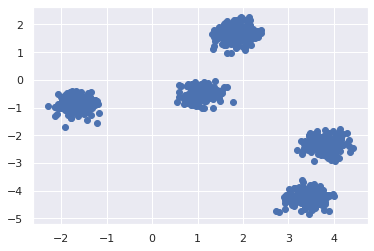

In [243]:
true_dist = np.reshape(gaussian_d.sample(1000), (1000, 2))
print(true_dist.shape)
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(true_dist[:,0], true_dist[:,1])
plt.show()

[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[121 183 223 203 270]
(1000, 2)
0
[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[126 208 221 207 262]
0
[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[119 202 212 175 316]
1
[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[141 177 220 203 283]
2
[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[126 195 210 210 283]
3
[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[126 179 222 218 279]
4
[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[149 170 241 195 269]
5
[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[131 191 220 189 293]
6
[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[129 187 229 202 277]
7
[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[118 158 236 210 302]
8
[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[118 180 237 187 302]
9
[0.12887399 0.18363815 0.21682219 0.19334826 0.27731741]
[131 187 214 196 296]
10
[0.12887399 0.183

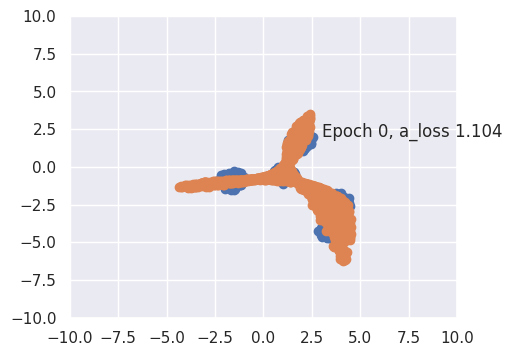

In [244]:
import warnings
warnings.filterwarnings('ignore')

batch_size = 1024
sns.set()
fig, ax = plt.subplots(dpi=100, figsize=(5, 4))
true_dist = np.reshape(gaussian_d.sample(1000), (1000, 2))
print(true_dist.shape)

def animate(step):
      print(step)
  # for iter in range(step):
      # generate data
      # first we sample from the true distribution, then we generate some
      # "fake" data by feeding noise to the generator
      true_sample = np.reshape(gaussian_d.sample(batch_size), (batch_size, 2))
      noise = generator_d.sample(batch_size)
      fake_sample = g.predict(noise)
      #pdb.set_trace()
      
      # train discriminator
      # feed true and fake samples with respective labels (1, 0) to the discriminator
      x = np.reshape(np.concatenate((true_sample, fake_sample)), (batch_size*2, 2))
      y = np.ones([batch_size*2, 1])
      y[batch_size:, :] = 0
      d_loss = discriminator_model.train_on_batch(x, y)
      
      # train GAN
      # feed noise to the model and expect true (1) response from discriminator,
      # which is in turn fed with data generated by the generator
      noise = np.reshape(generator_d.sample(batch_size), (batch_size, 2))
      y = np.ones([batch_size, 1])
      a_loss = adversarial_model.train_on_batch(noise, y)
      
      log_mesg = "%d: [D loss: %f, acc: %f]" % (step, d_loss[0], d_loss[1])
      log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])

      # plot
      fig.clf()
      plt.scatter(true_sample[:,0], true_sample[:,1])
      plt.scatter(fake_sample[:,0], fake_sample[:,1])
      plt.xlim([-10,10])
      plt.ylim([-10,10])
      plt.text(3, 2, "Epoch {}, a_loss {:.3f}".format(step, a_loss[0]))
    
anim = animation.FuncAnimation(fig, animate, frames=1000, interval = 20)
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

In [ ]:
noise = generator_d.sample(batch_size)
fake_sample = g.predict(noise)

In [ ]:
import matplotlib.pyplot as plt
true_sample = np.reshape(gaussian_d.sample(batch_size), (batch_size, 2))
plt.figure(figsize=(5,5))
plt.scatter(true_sample[:, 0], true_sample[:, 1]) 
plt.scatter(fake_sample[:, 0], fake_sample[:, 1])
plt.savefig('hello' + ".png", format="png")

[0.15918471 0.12020129 0.35038916 0.14500857 0.22521627]
[ 9 10 22 10 13]


<IPython.core.display.Javascript object>

[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[291 218  71 301 119]
(1000, 2)
0
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[15 15  8 16 10]
0
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[19 15  6 16  8]
1
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[14 19  5 19  7]
2
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[19 11 11 16  7]
3
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[18 12  4 19 11]
4
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[18  9  9 17 11]
5
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[30  7  3 17  7]
6
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[19  7  7 21 10]
7
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[19 11  9 14 11]
8
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[19 12  9 18  6]
9
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[14 15  6 19 10]
10
[0.29573104 0.20915299 0.08752338 0.29040869 0.11718391]
[14  8  8 28  6

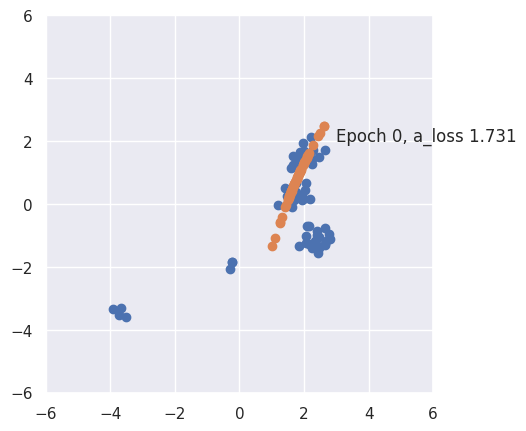

In [ ]:
import warnings
warnings.filterwarnings('ignore')

batch_size = 64
sns.set()
fig, ax = plt.subplots(dpi=100, figsize=(5,5))
true_dist = np.reshape(gaussian_d.sample(1000), (1000, 2))
print(true_dist.shape)

def animate(step):
      print(step)
  # for iter in range(step):
      # generate data
      # first we sample from the true distribution, then we generate some
      # "fake" data by feeding noise to the generator
      true_sample = np.reshape(gaussian_d.sample(batch_size), (batch_size, 2))
      noise = generator_d.sample(batch_size)
      fake_sample = g.predict(noise)
      #pdb.set_trace()
      
      # train discriminator
      # feed true and fake samples with respective labels (1, 0) to the discriminator
      x = np.reshape(np.concatenate((true_sample, fake_sample)), (batch_size*2, 2))
      y = np.ones([batch_size*2, 1])
      y[batch_size:, :] = 0
      d_loss = discriminator_model.train_on_batch(x, y)
      
      # train GAN
      # feed noise to the model and expect true (1) response from discriminator,
      # which is in turn fed with data generated by the generator
      noise = np.reshape(generator_d.sample(batch_size), (batch_size, 2))
      y = np.ones([batch_size, 1])
      a_loss = adversarial_model.train_on_batch(noise, y)
      
      log_mesg = "%d: [D loss: %f, acc: %f]" % (step, d_loss[0], d_loss[1])
      log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])

      # plot
      fig.clf()
      plt.scatter(true_sample[:, 0], true_sample[:, 1]) 
      plt.scatter(fake_sample[:, 0], fake_sample[:, 1])
      plt.xlim(-6, 6)
      plt.ylim(-6, 6)

      plt.text(3, 2, "Epoch {}, a_loss {:.3f}".format(step, a_loss[0]))
    
anim = animation.FuncAnimation(fig, animate, frames=1000, interval = 20)
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

In [ ]:
    'data is SxD'
    plt.figure(figsize=(5,5))
    plt.scatter(data[:, 0], data[:, 1]) 
    if filename:
        plt.savefig('./%s'%(filename) + ".png", format="png")

0 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
8 5
9 5
10 5
11 5
12 5
13 5
14 5
15 5
16 5
17 5
18 5
19 5
20 5
21 5
22 5
23 5
24 5
25 5
26 5
27 5
28 5
29 5
30 5
31 5
32 5
33 5
34 5
35 5
36 5
37 5
38 5
39 5
40 5
41 5
42 5


CalledProcessError: ignored

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
TypeError: animate() missing 1 required positional argument: 'argu'


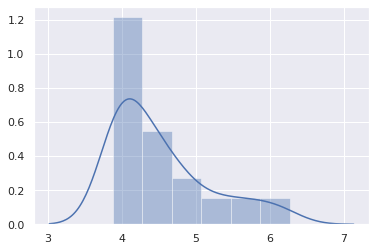

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

fig, ax1 = plt.subplots(1,1)

def animate(i,argu):
    print(i, argu)

    #graph_data = open('example.txt','r').read()
    graph_data = "1, 1 \n 2, 4 \n 3, 9 \n 4, 16 \n"
    lines = graph_data.split('\n')
    xs = []
    ys = []
    for line in lines:
        if len(line) > 1:
            x, y = line.split(',')
            xs.append(float(x))
            ys.append(float(y)+np.sin(2.*np.pi*i/10))
        ax1.clear()
        ax1.plot(xs, ys)
        plt.grid()

ani = animation.FuncAnimation(fig, animate, frames=200, interval = 20)
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()